# When can we start watching?
---
Henry Rachootin - December 2018

MIT License: https://opensource.org/licenses/MIT
---

BitTorrent allows people to download movies without staying strictly within the confines of the law, but because of the peer to peer nature of the download, the file will not download sequentially. The VLC player can play the incomplete movie, but if it encounters a missing piece while streaming it will fail.

Our pirate pirate friend is downloading _Avengers: Infinity War_, which is 149 minutes long and 12.91 GB. The torrent downloads in 4 MB pieces. If we start watching the movie when their torrent client says it is $x$ percent downloaded, What is the probability that we can get $t$ seconds into the movie without VLC failing on a missing piece?

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
from scipy.stats import poisson
from math import ceil,exp,floor
from thinkbayes2 import Suite
import thinkplot
import pandas as pd
from itertools import product

First we will just define some values.

Let's define $T$ to be the runtime of the movie in seconds and $N$ to be the number of 4 MB pieces in the movie. From these, we can define $t_p$, the runtime of a single 4 MB piece as $\frac{T}{N}$.

In [2]:
T   = 149*60             #movie runtime in seconds
N   = ceil(12.91*1000/4) #number of 4MB pieces in the whole movie
t_p = T/N                #runtime of a single 4MB piece

print(f"The runtime of a single piece is {t_p:.2f} seconds")

The runtime of a single piece is 2.77 seconds


Let's now consider where we are going with this calculation. When watching the movie, we need to have the next piece every 2.77 seconds. If we assume that each piece is equally likely to be downloaded, we can define a function $P_p(t)$ which tells us the probability of having a specific piece after $t$ seconds, and that will be the probability of having the next piece. We will find the actual form of $P_p(t)$ later.

We want to find $P(t)$, the probability of making it $t$ seconds into the movie without missing a piece. Let's define $n(t)=\lceil\frac{t}{t_p}\rceil$ to be the number of pieces needed to get $t$ seconds into the movie. We need to have each of those $n$ pieces at the time that they are played, and we have a function to tell us the probability that we will have them at that time. We can then say that

$$P(t)=\prod_{i=0}^{n(t)} P_p(i~t_p).$$

As for the actual form of $P_p(t)$, we will first find the distribution of the number of pieces downloaded at time $t$. Let's define the probability distribution $P_n(n,t)$, the probability of having $n$ pieces downloaded at time $t$. If we model piece arrival as a Poisson process, we can define $P_n(n,t)$ as

$$P_n(n,t)=\text{poisson}(n;\lambda t)$$

where $\lambda$ is the unknown mean piece arrival rate in pieces per second. We will find a distribution for $\lambda$ using real data. If we further assume that each piece is equally likely to be downloaded at any time, we can define $P_p(t)$ by the law of total probability as

$$P_p(t)=\sum_{n=n_0}^{N} \frac{n}{N}P_n(n-n_0,t)$$

where $n_0$ is the number of pieces downloaded when we start watching the movie, which we can just approximate as $\left\lfloor\frac{xN}{100}\right\rfloor$, were $x$ is still the percent downloaded at the start.

Of course, whatever probabilities we get out of that will be dependent on $\lambda$, so we will have to sum them over our probability distribution for $\lambda$, once we have that. We will use a grid algorithm to find that $\lambda$ distribution, by starting with a uniform prior for a number of sample $\lambda$ values and updating it with measured interarrival times, remembering that the likelihood of an interarrival time $t$ is $\lambda e^{\lambda t}$ for a poisson process.

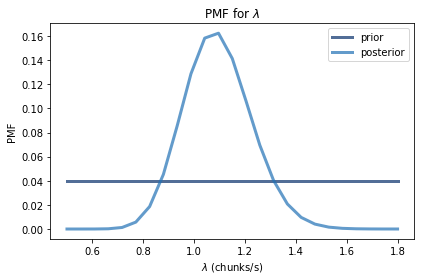

In [3]:
data = pd.read_csv('torrent pieces.csv')          #wireshark dump
data = data[data.Info=="Piece[Malformed Packet]"] #this finds the piece packets 
times = np.array(data.Time)                       #extract the time each piece arrived at
times = times[45:]  #dump the initial times, they don't represent the long term behavior
interTimes = np.diff(times)

class Lambda(Suite):
    def Likelihood(self, inter, lam):
        return lam*exp(-lam*inter)   #poisson process interarrival likelihood

lamPrior = np.linspace(0.5,1.8,25) #start with a uniform distribution for lambda
lam      = Lambda(lamPrior)
thinkplot.Pdf(lam,label='prior')
lam.UpdateSet(interTimes)
thinkplot.Pdf(lam,label='posterior')
thinkplot.decorate(title="PMF for $\lambda$",xlabel="$\lambda$ (pieces/s)",ylabel="PMF")

And we can implement all the functions we defined above:

In [4]:
def P_n(n,t,lam): #probability of having exactly n pieces at time t for rate lambda
    return poisson.pmf(n,lam*t)

def P_p(t,n_0,lam): #probability of having a specific piece at time t for rate lambda
    ns = np.array(range(n_0,N+1))   #all the numbers of pieces there could be
    ps = P_n(ns-n_0,t,lam)          #the probabilities of having them
    P  = np.sum(ps)             #the total probability 
                                #(since we are cutting off the poisson distribution at N
                                #this is not always 1)
    if(P==0):
        return 1 #if lam*t is so large that we have cut off the whole poisson distribution, we can
                 #just assume that we will have downloaded the whole movie
    return np.sum(ns*ps)/(N*P)

def P(t,n_0,lam): #probability of getting to time t without missing a piece
    nt = ceil(t/t_p)             #total pieces we will need
    ts = np.array(range(nt))*t_p #times we need each piece at
    ps = np.array([P_p(t,n_0,lam) for t in ts]) #probabilitis of having each piece in time
    return np.product(ps)                       #total probability

With those done, we can make our final $P(t,x)$ function, which will give us the probability of getting to time $t$ if we start at $x$ percent downloaded with our derived distribution for $\lambda$.

In [5]:
def PWatch(t,x):
    n0    = floor(x*N/100) #intial piece number approximation
    Ptot  = 0
    for l,p in lam.Items(): #law of total probability
        Ptot += p*P(t,n0,l)
    return Ptot

Unfortunately that function is prohibitively slow. We can speed it up quite a lot by improving our $P_p$ function to be less accurate but much faster. We will approximate it by

$$P_p(t)=\frac{\min(\lambda t+n_0,N)}{N}$$

which is just assuming that we get one piece every $\lambda$ seconds. This ignores the uncertanty of the poisson distribution, but is much faster to calculate since it does not involve a sum.

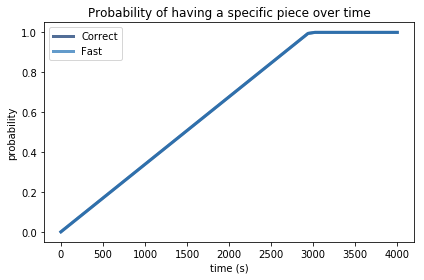

In [48]:
def P_p_fast(t,n_0,lam):
    return min(lam*t+n_0,N)/N

testLam = lam.Mean()
ts = np.linspace(0,4000)
ps = np.array([P_p(t,0,testLam) for t in ts])
psFast = np.array([P_p_fast(t,0,testLam) for t in ts])
thinkplot.plot(ts,ps,label='Correct')
thinkplot.plot(ts,psFast,label='Fast')
thinkplot.decorate(title='Probability of having a specific piece over time',
                  xlabel='time (s)',
                  ylabel='probability')

From the graph we can see that this is an ok approximation.

With that done, we can start making graphs and answering the original question.

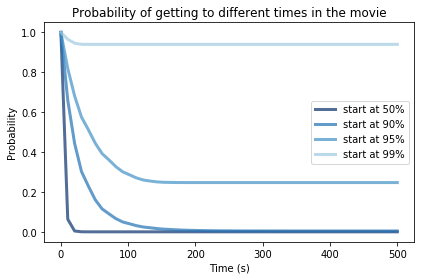

In [41]:
P_p = P_p_fast #use the fast function from now on

ts = np.linspace(0,500)
xs = [50,90,95,99]

for x in xs:
    ps = [PWatch(t,x) for t in ts]
    thinkplot.plot(ts,ps,label=f'start at {x}%')
    thinkplot.decorate(title='Probability of getting to different times in the movie',
                      xlabel='Time (s)',
                      ylabel='Probability')

That graph is zoomed in near the start of the movie, but here's what it looks like over the whole runtime:

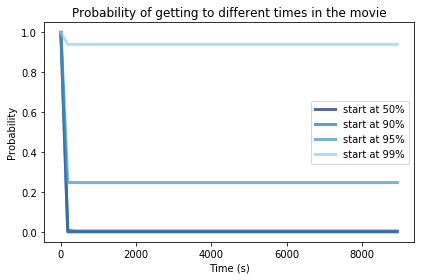

In [42]:
ts = np.linspace(0,T)
xs = [50,90,95,99]

for x in xs:
    ps = [PWatch(t,x) for t in ts]
    thinkplot.plot(ts,ps,label=f'start at {x}%')
    thinkplot.decorate(title='Probability of getting to different times in the movie',
                      xlabel='Time (s)',
                      ylabel='Probability')

So we can see there is a definite falling off period, and after that we will probably finish the movie. With that in mind, we can ask what the probability of finishing the movie will be for different starting percentages.

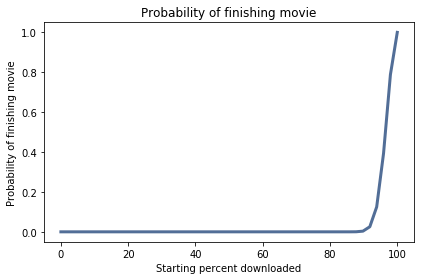

In [46]:
xs = np.linspace(0,100)
ps = [PWatch(T,x) for x in xs]
thinkplot.plot(xs,ps)
thinkplot.decorate(title='Probability of finishing movie',
                      xlabel='Starting percent downloaded',
                      ylabel='Probability of finishing movie')

Here's the nonzero portion of that graph:

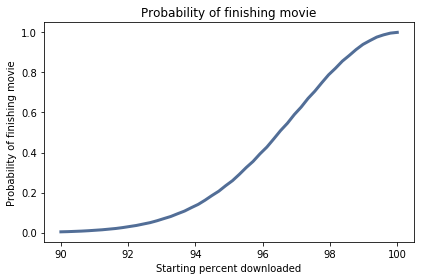

In [47]:
xs = np.linspace(90,100)
ps = [PWatch(T,x) for x in xs]
thinkplot.plot(xs,ps)
thinkplot.decorate(title='Probability of finishing movie',
                      xlabel='Starting percent downloaded',
                      ylabel='Probability of finishing movie')

So we can see that you need to wait until about 90% has downloaded before we can expect to have any chance of finishing, and then the probability picks up rather quickly between 95% and 100%.